In [53]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch
from transformers import (SegformerImageProcessor, SegformerConfig)
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3  # Ajusta si tienes diferente número de clases
IMAGE_SIZE = 256

In [54]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, mask_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

def get_image_mask_paths(folder):
    image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png")) and "_mask" not in f])
    mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in image_files]
    return image_files, mask_files

In [55]:
dataset_path = "content/my-datasets"
test_path = os.path.join(dataset_path, "test")

test_images, test_masks = get_image_mask_paths(test_path)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_dataset = CustomSegmentationDataset(
    image_dir=test_path,
    mask_dir=test_path,
    image_files=test_images,
    mask_files=test_masks,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [56]:
model_paths = {
    "UNET": "../best_models/UNET.pth",
    "DEEPLABV3+": "../best_models/DEEPLAB.pth",
    "SEGFORMER": "../best_models/SEGFORMER.pth"
}

# Procesador para SEGFORMER
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

id2label = {
    2: "suelo expuesto",
    3: "vegetacion seca",
    4: "vegetacion verde"
}
label2id = {v: k for k, v in id2label.items()}

# Configuración personalizada
config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id
)

def load_model(model_name, model_path):
    # Cargar directamente el modelo completo desde el archivo .pth
    model = torch.load(model_path, map_location=DEVICE, weights_only=False)
    
    model = model.to(DEVICE)
    model.eval()
    return model

/home/jose/.local/lib/python3.13/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [57]:
def get_num_classes(model):
    # Modelos Hugging Face (como SegFormer)
    if hasattr(model, "config") and hasattr(model.config, "num_labels"):
        return model.config.num_labels
    
    # Modelos de segmentation_models_pytorch
    elif hasattr(model, "segmentation_head"):
        head = model.segmentation_head
        # Acceder al último Conv2d si está encapsulado
        if hasattr(head, 'out_channels'):
            return head.out_channels
        elif isinstance(head, torch.nn.Sequential):
            for layer in reversed(head):
                if isinstance(layer, torch.nn.Conv2d):
                    return layer.out_channels
        elif isinstance(head, torch.nn.Conv2d):
            return head.out_channels
    
    # Arquitecturas personalizadas tipo U-Net
    elif hasattr(model, "model") and isinstance(model.model[-1], torch.nn.Conv2d):
        return model.model[-1].out_channels
    
    raise ValueError("No se pudo determinar el número de clases del modelo.")

In [58]:
# Carga e imprime clases por modelo
for model_name, model_path in model_paths.items():
    model = load_model(model_name, model_path)
    num_classes = get_num_classes(model)
    print(f"{model_name} tiene {num_classes} clases")

UNET tiene 5 clases
DEEPLABV3+ tiene 5 clases
SEGFORMER tiene 5 clases


In [59]:
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Revierte la normalización de ImageNet aplicada a una imagen tensorial."""
    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

In [60]:
def plot_confusion_matrix(y_true, y_pred, labels, target_names, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

Evaluando modelo: UNET
Reporte de Clasificación:
                  precision    recall  f1-score   support

  suelo expuesto     0.8339    0.8278    0.8309    299600
 vegetacion seca     0.8510    0.8393    0.8451    378427
vegetacion verde     0.8435    0.8695    0.8563    239477

        accuracy                         0.8434    917504
       macro avg     0.8428    0.8455    0.8441    917504
    weighted avg     0.8435    0.8434    0.8434    917504



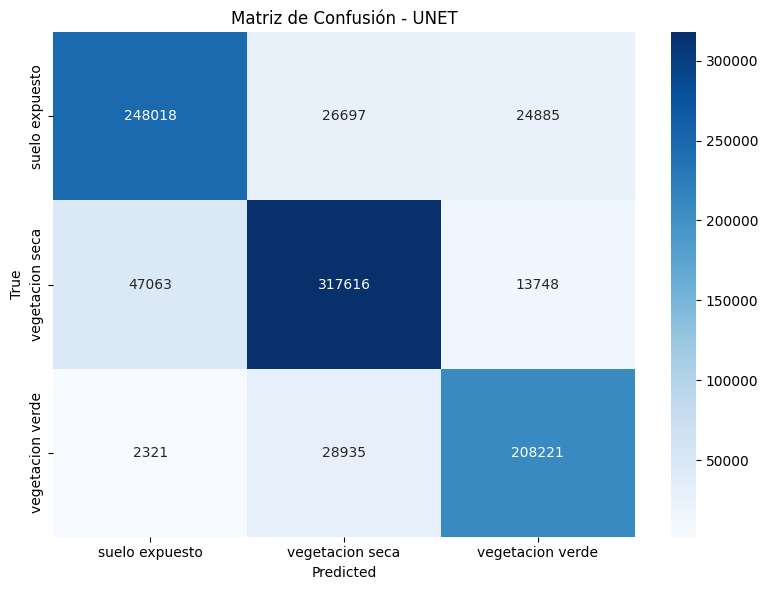


IoU Promedio:
0.7303735524231466

Precisión de píxeles: 0.8434

------------------------------------------------------------

Evaluando modelo: DEEPLABV3+
Reporte de Clasificación:
                  precision    recall  f1-score   support

  suelo expuesto     0.6786    0.7799    0.7258    300015
 vegetacion seca     0.7650    0.6058    0.6762    377936
vegetacion verde     0.7797    0.8900    0.8312    239553

        accuracy                         0.7369    917504
       macro avg     0.7411    0.7586    0.7444    917504
    weighted avg     0.7406    0.7369    0.7329    917504



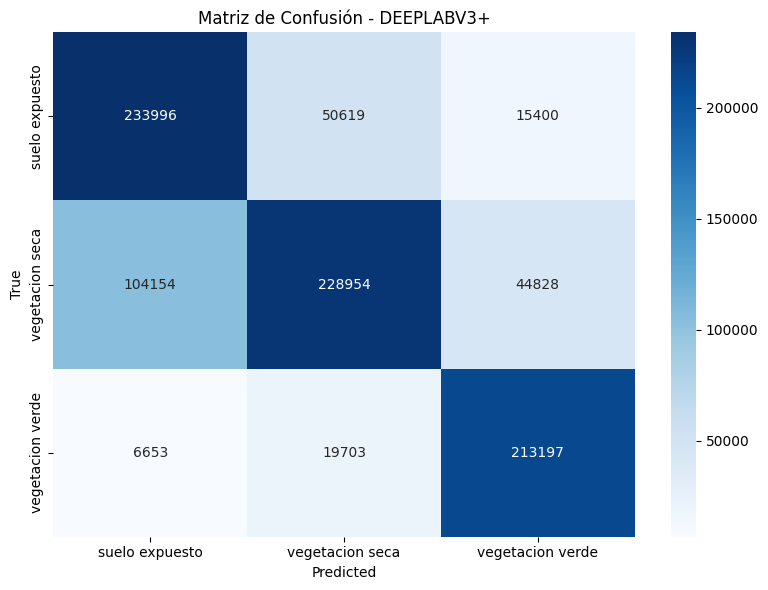


IoU Promedio:
0.597173242737314

Precisión de píxeles: 0.7369

------------------------------------------------------------

Evaluando modelo: SEGFORMER
Reporte de Clasificación:
                  precision    recall  f1-score   support

  suelo expuesto     0.8196    0.9214    0.8675    299685
 vegetacion seca     0.8889    0.7582    0.8184    378250
vegetacion verde     0.8129    0.8754    0.8430    239569

        accuracy                         0.8421    917504
       macro avg     0.8405    0.8517    0.8430    917504
    weighted avg     0.8464    0.8421    0.8408    917504



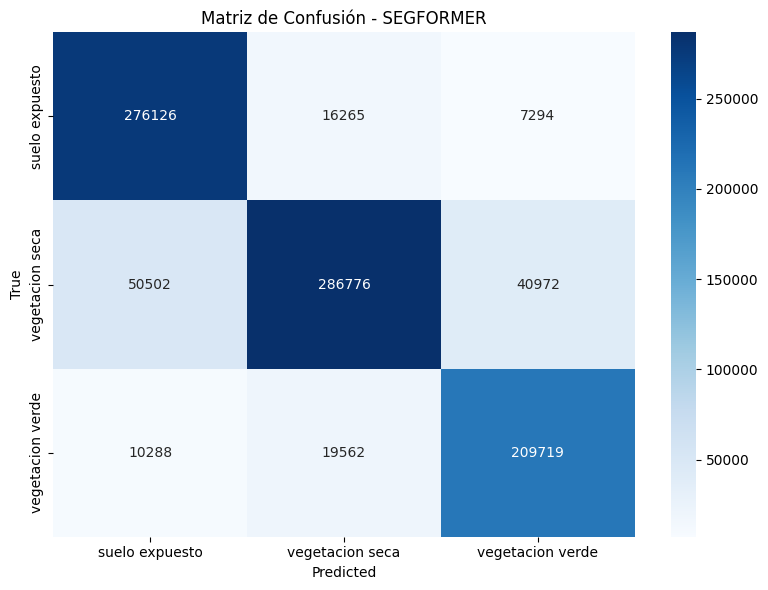


IoU Promedio:
0.72906040330196

Precisión de píxeles: 0.8421

------------------------------------------------------------



In [61]:
# Mapeo completo de clases posibles
id2label_full = {
    0: "fondo",
    1: "agua",
    2: "suelo expuesto",
    3: "vegetacion seca",
    4: "vegetacion verde"
}

# Detectar dinámicamente todas las clases presentes en las máscaras
all_labels = set()
for _, masks in test_loader:
    for mask in masks:
        unique = torch.unique(mask)
        all_labels.update(unique.cpu().numpy())

labels = sorted(list(all_labels))
target_names = [id2label_full[i] for i in labels]

for model_name, model_path in model_paths.items():
    print(f"Evaluando modelo: {model_name}")
    model = load_model(model_name, model_path)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            if model_name == "SEGFORMER":
                for i in range(imgs.shape[0]):
                    img = denormalize(imgs[i])
                    img = img.permute(1, 2, 0).cpu().numpy()
                    img = np.clip(img, 0, 1)

                    inputs = feature_extractor(images=img, return_tensors="pt", do_rescale=False).to(DEVICE)
                    outputs = model(**inputs)
                    logits = outputs.logits

                    logits = torch.nn.functional.interpolate(
                        logits,
                        size=masks[i].shape[-2:],
                        mode="bilinear",
                        align_corners=False
                    )

                    pred = torch.argmax(logits, dim=1).squeeze(0)

                    y_true.append(masks[i].view(-1).cpu().numpy())
                    y_pred.append(pred.view(-1).cpu().numpy())
            else:
                outputs = model(imgs)
                preds = torch.argmax(outputs, dim=1)

                y_true.append(masks.view(-1).cpu().numpy())
                y_pred.append(preds.view(-1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    print("Reporte de Clasificación:")
    print(classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        zero_division=0,
        digits=4
    ))

    plot_confusion_matrix(y_true, y_pred, labels=labels, target_names=target_names, model_name=model_name)

    print("\nIoU Promedio:")
    print(jaccard_score(y_true, y_pred, average='macro', labels=labels))

    acc = (y_true == y_pred).sum() / len(y_true)
    print(f"\nPrecisión de píxeles: {acc:.4f}\n")

    dashes = "---"

    print(f"{dashes*20}\n")